In [1]:
# 1. RGB 이미지에서 DINOv2 특징 추출
# 2. 2D keypoints 예측 MLP 학습
# 3. Joiot angle 예측 MLP 학습
# 4. Fk로 3D 포즈 계산
# 5. 3D 포즈와 2D keypoints PnP로 카메라 포즈 계산
# 6. Extrinsic Matrix 계산 및 저장

In [2]:
import os
import glob
import json
import numpy as np
import random
import wandb
import threading

import cv2
import math
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm 

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR # 상단에 추가
import kornia.augmentation as K

from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

NUM_ANGLES = 7
NUM_JOINTS = 8
FEATURE_DIM = 768
HEATMAP_SIZE = (128, 128)

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"
is_available = torch.cuda.is_available()

if is_available:
    # 2. 사용 가능한 GPU 개수 확인
    gpu_count = torch.cuda.device_count()
    print(f"✅ 사용 가능한 GPU가 감지되었습니다.")
    print(f"GPU 개수: {gpu_count}개")

# --- 설정 변수 ---
# CSV 파일의 전체 경로를 지정합니다.
TOTAL_CSV_PATH = '../dataset/franka_research3/fr3_matched_joint_angle.csv'

# --- 1. CSV 파일 로드 ---
try:
    print(f"Loading data from {TOTAL_CSV_PATH}...")
    total_csv = pd.read_csv(TOTAL_CSV_PATH)
    print("✅ CSV file loaded successfully.")
except FileNotFoundError:
    print(f"❌ ERROR: CSV file not found at {TOTAL_CSV_PATH}")
    exit() # 파일이 없으면 프로그램 종료

# --- 2. 데이터 쌍 리스트 초기화 ---
dataset_pairs = []

# --- 3. CSV의 각 행을 순회하며 데이터 쌍 생성 ---
# tqdm을 사용하여 진행 상황을 표시합니다.
print("Processing CSV rows to create dataset pairs...")
for index, row in tqdm(total_csv.iterrows(), total=len(total_csv), desc="Creating pairs"):
    # 이미지 경로 추출
    image_path = row['image_path']
    
    # 7개의 관절 위치(position) 값을 리스트로 추출
    # 컬럼 이름 (position_fr3_joint1, position_fr3_joint2, ...)
    try:
        joint_angles = [row[f'position_fr3_joint{j}'] for j in range(1, NUM_ANGLES + 1)]
        
        # 데이터 쌍을 딕셔너리 형태로 생성
        pair = {
            'image_path': image_path,
            'joint_angles': joint_angles
        }
        
        # 최종 리스트에 추가
        dataset_pairs.append(pair)
        
    except KeyError as e:
        print(f"\n⚠️ Warning: Column not found ({e}), skipping row {index}.")


# --- 4. 결과 확인 ---
print(f"\n✅ Total {len(dataset_pairs)} pairs found.")

if dataset_pairs:
    print("\n--- Sample of matched pairs (first 5) ---")
    for i in range(min(5, len(dataset_pairs))):
        pair = dataset_pairs[i]
        # os.path.basename을 사용하여 파일 이름만 깔끔하게 출력
        print(f"Image: {os.path.basename(pair['image_path'])}")
        # joint_angles는 소수점 4자리까지만 표시
        formatted_angles = [f"{angle:.4f}" for angle in pair['joint_angles']]
        print(f"Joint Angles: {formatted_angles}")
        print("-" * 20)

/home/najo/.conda/envs/dinov3/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/najo/.conda/envs/dinov3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 사용 가능한 GPU가 감지되었습니다.
GPU 개수: 3개
Loading data from ../dataset/franka_research3/fr3_matched_joint_angle.csv...
✅ CSV file loaded successfully.
Processing CSV rows to create dataset pairs...


Creating pairs: 100%|██████████| 16156/16156 [00:00<00:00, 18607.76it/s]


✅ Total 16156 pairs found.

--- Sample of matched pairs (first 5) ---
Image: zed_49045152_left_1756275914.271.jpg
Joint Angles: ['0.6480', '-0.1083', '0.2098', '-1.9201', '0.8858', '3.1025', '-2.3876']
--------------------
Image: zed_49045152_right_1756275914.271.jpg
Joint Angles: ['0.6480', '-0.1083', '0.2098', '-1.9201', '0.8858', '3.1025', '-2.3876']
--------------------
Image: zed_41182735_right_1756275914.348.jpg
Joint Angles: ['0.6568', '-0.1068', '0.1993', '-1.9216', '0.8694', '3.0918', '-2.3762']
--------------------
Image: zed_41182735_left_1756275914.348.jpg
Joint Angles: ['0.6568', '-0.1068', '0.1993', '-1.9216', '0.8694', '3.0918', '-2.3762']
--------------------
Image: zed_49429257_right_1756275914.401.jpg
Joint Angles: ['0.6659', '-0.1053', '0.1888', '-1.9231', '0.8529', '3.0811', '-2.3646']
--------------------


In [3]:
def create_gt_heatmap(keypoint_2d, HEATMAP_SIZE, sigma):
    H, W = HEATMAP_SIZE
    x, y = keypoint_2d
    xx, yy = np.meshgrid(np.arange(W), np.arange(H))
    dist_sq = (xx - x)**2 + (yy - y)**2
    exponent = dist_sq / (2 * sigma**2)
    heatmap = np.exp(-exponent)
    heatmap[heatmap < np.finfo(float).eps * heatmap.max()] = 0
    return heatmap

def get_modified_dh_matrix(a, d, alpha, theta):
    """Craig식 Modified DH: T = Rx(alpha) @ Tx(a) @ Rz(theta) @ Tz(d)"""
    alpha_rad = math.radians(alpha)
    theta_rad = math.radians(theta)

    Rx = np.array([
        [1, 0, 0, 0],
        [0, np.cos(alpha_rad), -np.sin(alpha_rad), 0],
        [0, np.sin(alpha_rad),  np.cos(alpha_rad), 0],
        [0, 0, 0, 1]
    ])
    Tx = np.array([
        [1, 0, 0, a],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    Rz = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad), 0, 0],
        [np.sin(theta_rad),  np.cos(theta_rad), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    Tz = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, d],
        [0, 0, 0, 1]
    ])
    return Rx @ Tx @ Rz @ Tz

def angle_to_joint_coordinate(joint_angles, selected_view):
    """Converts 7 joint angles to 3D coordinates using forward kinematics."""
    # DH Parameters for Franka Research 3 (FR3) robot (meters and degrees)
    # IMPORTANT: Verify these parameters match your robot.
    fr3_dh_parameters = [
        {'a': 0,      'd': 0.333, 'alpha':   0, 'theta_offset': 0}, #1
        {'a': 0,      'd': 0,     'alpha': -90, 'theta_offset': 0}, #2
        {'a': 0,      'd': 0.316, 'alpha':  90, 'theta_offset': 0}, #3
        {'a': 0.0825,  'd': 0,     'alpha':  90, 'theta_offset': 0}, #4
        {'a': -0.0825, 'd': 0.384, 'alpha': -90, 'theta_offset': 0}, #5
        {'a': 0,      'd': 0,     'alpha':  90, 'theta_offset': 0}, #6
        {'a': 0.088,  'd': 0,     'alpha':  90, 'theta_offset': 0}, #7 
        {'a': 0,      'd': 0.107, 'alpha':   0, 'theta_offset': 0}  # flanger
    ]
    
    # Rotational correction for the robot base depending on the camera view
    view_rotations = {
        'view1': R.from_euler('zyx', [90, 180, 0], degrees=True), # Front (reference)
        'view4': R.from_euler('zyx', [90, 180, 0], degrees=True), # Top
        'view3': R.from_euler('zyx', [90, 180, 0], degrees=True), # Left
        'view2': R.from_euler('zyx', [90, 180, 0], degrees=True)  # Right
    }
    
    T_base_correction = np.eye(4)
    if selected_view in view_rotations:
        T_base_correction[:3, :3] = view_rotations[selected_view].as_matrix()

    T_cumulative = T_base_correction
    joint_coords_3d = [np.array([0, 0, 0])] # J0 (base) position
    
    base_point = np.array([[0], [0], [0], [1]])
    for i, angle_rad in enumerate(joint_angles):
        params = fr3_dh_parameters[i]
        theta_deg = math.degrees(angle_rad) + params['theta_offset']
        
        T_i = get_modified_dh_matrix(params['a'], params['d'], params['alpha'], theta_deg)
        T_cumulative = T_cumulative @ T_i
        
        joint_pos = T_cumulative @ base_point
        joint_coords_3d.append(joint_pos[:3, 0])
        
    return np.array(joint_coords_3d, dtype=np.float32)

def joint_coordinate_to_pixel_plane(coords_3d, aruco_result, camera_matrix, dist_coeffs):
    """Projects 3D coordinates onto the 2D image plane."""
    Rvec = np.array([
        aruco_result['rvec_x'],
        aruco_result['rvec_y'],
        aruco_result['rvec_z']
    ], dtype=np.float32)
    Tvec = np.array([
        aruco_result['tvec_x'],
        aruco_result['tvec_y'],
        aruco_result['tvec_z']
    ], dtype=np.float32).reshape(3, 1)

    pixel_coords, _ = cv2.projectPoints(
        coords_3d, Rvec, Tvec, camera_matrix, dist_coeffs
    )
    return pixel_coords.reshape(-1, 2)

class RobotPoseDataset(Dataset):
    def __init__(self, pairs, transform=None, HEATMAP_SIZE=(128, 128), sigma=5.0):
        self.pairs = pairs
        self.transform = transform
        self.heatmap_size = HEATMAP_SIZE
        self.sigma = sigma

        print("Loading and preprocessing metadata for pose1 and pose2...")
        # --- 1. pose1과 pose2의 ArUco 데이터를 모두 불러와 하나의 조회 테이블로 통합 ---
        self.aruco_lookup = {}

        # pose1 데이터 로드 및 추가
        pose1_aruco_path = '../dataset/franka_research3/pose1_aruco_pose_summary.json'
        with open(pose1_aruco_path, 'r') as f:
            pose1_aruco_results_all = json.load(f)
        for item in pose1_aruco_results_all:
            # 'pose1_view1_leftcam'과 같은 고유한 키 생성
            key = f"pose1_{item['view']}_{item['cam']}"
            self.aruco_lookup[key] = item

        # pose2 데이터 로드 및 추가
        pose2_aruco_path = '../dataset/franka_research3/pose2_aruco_pose_summary.json'
        with open(pose2_aruco_path, 'r') as f:
            pose2_aruco_results_all = json.load(f)
        for item in pose2_aruco_results_all:
            # 'pose2_view1_leftcam'과 같은 고유한 키 생성
            key = f"pose2_{item['view']}_{item['cam']}"
            self.aruco_lookup[key] = item
            
        # --- 2. Calibration 데이터 로드 ---
        self.calib_lookup = {}
        calib_dir = "../dataset/franka_research3/Calib_cam_from_conf"
        calib_files = glob.glob(os.path.join(calib_dir, "*.json"))
        for calib_path in calib_files:
            filename = os.path.basename(calib_path).replace("_calib.json", "")
            with open(calib_path, 'r') as f:
                self.calib_lookup[filename] = json.load(f)
                
        print(f"✅ Metadata loaded. Found {len(self.aruco_lookup)} ArUco entries and {len(self.calib_lookup)} calibration files.")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        image_path = pair['image_path']
        
        try:
            # --- 파일 경로 분석 ---
            filename = os.path.basename(image_path)
            parts = filename.split('_')
            serial_str = parts[1]
            selected_cam = parts[2] + "cam"

            serial_to_view = {
                '41182735': "view1", '49429257': "view2",
                '44377151': "view3", '49045152': "view4"
            }
            selected_view = serial_to_view[serial_str]

            # --- 이미지 처리 ---
            calib_key = f"{selected_view}_{serial_str}_{selected_cam}"
            calib = self.calib_lookup[calib_key]
            camera_matrix = np.array(calib["camera_matrix"], dtype=np.float32)
            dist_coeffs = np.array(calib["distortion_coeffs"], dtype=np.float32)
            
            image = Image.open(image_path).convert('RGB')
            image_np = np.array(image)
            undistorted_image_np = cv2.undistort(image_np, camera_matrix, dist_coeffs)
            undistorted_image = Image.fromarray(undistorted_image_np)

            if self.transform:
                image_tensor = self.transform(undistorted_image)
            else: # transform이 없는 경우를 대비
                image_tensor = transforms.ToTensor()(undistorted_image)

            # --- 3. 이미지 경로에 따라 pose1/pose2를 구분하여 ArUco 키 생성 ---
            if 'pose1' in image_path:
                pose_name = 'pose1'
            elif 'pose2' in image_path:
                pose_name = 'pose2'
            else:
                raise ValueError(f"Image path does not contain 'pose1' or 'pose2': {image_path}")

            aruco_key = f"{pose_name}_{selected_view}_{selected_cam}"
            aruco_result = self.aruco_lookup[aruco_key]
            
            # --- 4. Joint 데이터를 pair에서 직접 가져오기 ---
            joint_angle_data = pair['joint_angles']
            gt_angles = torch.tensor(joint_angle_data, dtype=torch.float32)
            
            # --- 좌표 변환 및 히트맵 생성 ---
            joint_coords = angle_to_joint_coordinate(joint_angle_data, selected_view)
            pixel_coords = joint_coordinate_to_pixel_plane(joint_coords, aruco_result, camera_matrix, dist_coeffs)
            
            num_joints = len(pixel_coords)
            original_h, original_w, _ = undistorted_image_np.shape

            # 스케일링
            scaled_keypoints = np.zeros_like(pixel_coords)
            scaled_keypoints[:, 0] = pixel_coords[:, 0] * (self.heatmap_size[1] / original_w) # x
            scaled_keypoints[:, 1] = pixel_coords[:, 1] * (self.heatmap_size[0] / original_h) # y

            # 히트맵 생성
            gt_heatmaps_np = np.zeros((num_joints, self.heatmap_size[0], self.heatmap_size[1]), dtype=np.float32)
            for i in range(num_joints):
                gt_heatmaps_np[i] = create_gt_heatmap(scaled_keypoints[i], self.heatmap_size, self.sigma)
            
            gt_heatmaps = torch.from_numpy(gt_heatmaps_np)

            return image_tensor, gt_heatmaps, gt_angles

        except KeyError as e:
            print(f"❌ Error processing '{image_path}': Key {e} not found in lookup tables. Check file names and JSON content.")
            # 에러 발생 시 None을 반환하도록 하여 DataLoader에서 제외시킬 수 있습니다 (collate_fn 수정 필요).
            # 여기서는 에러를 발생시켜 문제를 즉시 파악하도록 합니다.
            raise e
        except Exception as e:
            print(f"❌ An unexpected error occurred with '{image_path}': {e}")
            raise e

In [4]:
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModel
from transformers.image_utils import load_image

class DINOv2Backbone(nn.Module):
    def __init__(self, model_name='vit_base_patch14_dinov2.lvd142m'):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True)

    def forward(self, image_tensor_batch): # 입력이 텐서 배치로 변경
        with torch.no_grad():
            features = self.model.forward_features(image_tensor_batch)
            patch_tokens = features[:, 1:, :]
        return patch_tokens

class JointAngleHead(nn.Module):
    def __init__(self, input_dim=FEATURE_DIM, num_angles=NUM_ANGLES, num_queries=4, nhead=8, num_decoder_layers=2):
        """
        어텐션을 사용하여 이미지 특징에서 핵심 정보를 추출하는 헤드.

        Args:
            input_dim (int): DINOv2 특징 벡터의 차원.
            num_angles (int): 예측할 관절 각도의 수.
            num_queries (int): 포즈 정보를 추출하기 위해 사용할 학습 가능한 쿼리의 수.
            nhead (int): Multi-head Attention의 헤드 수.
            num_decoder_layers (int): Transformer Decoder 레이어의 수.
        """
        super().__init__()
        
        # 1. "로봇 포즈에 대해 질문하는" 학습 가능한 쿼리 토큰 생성
        self.pose_queries = nn.Parameter(torch.randn(1, num_queries, input_dim))
        
        # 2. PyTorch의 표준 Transformer Decoder 레이어 사용
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=input_dim, 
            nhead=nhead, 
            dim_feedforward=input_dim * 4, # 일반적인 설정
            dropout=0.1, 
            activation='gelu',
            batch_first=True  # (batch, seq, feature) 입력을 위함
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        # 3. 최종 각도 예측을 위한 MLP
        # 디코더를 거친 모든 쿼리 토큰의 정보를 사용
        self.angle_predictor = nn.Sequential(
            nn.LayerNorm(input_dim * num_queries),
            nn.Linear(input_dim * num_queries, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Linear(256, num_angles)
        )

    def forward(self, fused_features):
        # fused_features: DINOv2의 패치 토큰들 (B, Num_Patches, Dim)
        # self.pose_queries: 학습 가능한 쿼리 (1, Num_Queries, Dim)
        
        # 배치 사이즈만큼 쿼리를 복제
        b = fused_features.size(0)
        queries = self.pose_queries.repeat(b, 1, 1)
        
        # Transformer Decoder 연산
        # 쿼리(queries)가 이미지 특징(fused_features)에 어텐션을 수행하여
        # 포즈와 관련된 정보로 자신의 값을 업데이트합니다.
        attn_output = self.transformer_decoder(tgt=queries, memory=fused_features)
        
        # 업데이트된 쿼리 토큰들을 하나로 펼쳐서 MLP에 전달
        output_flat = attn_output.flatten(start_dim=1)
        
        return self.angle_predictor(output_flat)

class TokenFuser(nn.Module):
    """
    ViT의 패치 토큰(1D 시퀀스)을 CNN이 사용하기 좋은 2D 특징 맵으로 변환하고 정제합니다.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.refine_blocks = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        # x: (B, D, H, W) 형태로 reshape된 토큰 맵
        projected = self.projection(x)
        refined = self.refine_blocks(projected)
        residual = self.residual_conv(x)
        return torch.nn.functional.gelu(refined + residual)

class LightCNNStem(nn.Module):
    """
    UNet의 인코더처럼 고해상도의 공간적 특징(shallow features)을 
    여러 스케일로 추출하기 위한 경량 CNN.
    """
    def __init__(self):
        super().__init__()
        # 간단한 CNN 블록 구성
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False), # 해상도 1/2
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False), # 해상도 1/4
            nn.BatchNorm2d(32),
            nn.GELU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False), # 해상도 1/8
            nn.BatchNorm2d(64),
            nn.GELU()
        )
        
    def forward(self, x):
        # x: 원본 이미지 텐서 배치 (B, 3, H, W)
        feat_4 = self.conv_block1(x)  # 1/4 스케일 특징
        feat_8 = self.conv_block2(feat_4) # 1/8 스케일 특징
        return feat_4, feat_8 # 다른 해상도의 특징들을 반환

class FusedUpsampleBlock(nn.Module):
    """
    업샘플링된 특징과 CNN 스템의 고해상도 특징(스킵 연결)을 융합하는 블록.
    """
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.refine_conv = nn.Sequential(
            nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x, skip_feature):
        x = self.upsample(x)
        
        # ✅ 해결책: skip_feature를 x의 크기에 강제로 맞춥니다.
        # ----------------------------------------------------------------------
        # 두 텐서의 높이와 너비가 다를 경우, skip_feature를 x의 크기로 리사이즈합니다.
        if x.shape[-2:] != skip_feature.shape[-2:]:
            skip_feature = F.interpolate(
                skip_feature, 
                size=x.shape[-2:], # target H, W
                mode='bilinear', 
                align_corners=False
            )
        # ----------------------------------------------------------------------
        
        # 이제 두 텐서의 크기가 같아졌으므로 안전하게 합칠 수 있습니다.
        fused = torch.cat([x, skip_feature], dim=1)
        return self.refine_conv(fused)
    
class UNetViTKeypointHead(nn.Module):
    def __init__(self, input_dim=768, num_joints=7, heatmap_size=(128, 128)):
        super().__init__()
        self.heatmap_size = heatmap_size
        self.token_fuser = TokenFuser(input_dim, 256)
        self.decoder_block1 = FusedUpsampleBlock(in_channels=256, skip_channels=64, out_channels=128)
        self.decoder_block2 = FusedUpsampleBlock(in_channels=128, skip_channels=32, out_channels=64)
        self.final_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.heatmap_predictor = nn.Conv2d(64, num_joints, kernel_size=3, padding=1)

    def forward(self, dino_features, cnn_features):
        cnn_feat_4, cnn_feat_8 = cnn_features

        # 1. DINOv3 토큰을 표준 ViT 패치 개수인 196개로 잘라내고 2D 맵으로 변환
        num_patches_to_keep = 196
        dino_features_sliced = dino_features[:, :num_patches_to_keep, :]
        
        b, n, d = dino_features_sliced.shape
        h = w = int(n**0.5)
        x = dino_features_sliced.permute(0, 2, 1).reshape(b, d, h, w)

        x = self.token_fuser(x)

        # 2. 디코더 업샘플링 & 융합
        x = self.decoder_block1(x, cnn_feat_8)
        x = self.decoder_block2(x, cnn_feat_4)
        
        # 3. 최종 해상도로 업샘플링 및 예측
        x = self.final_upsample(x)
        heatmaps = self.heatmap_predictor(x)
        
        return F.interpolate(heatmaps, size=self.heatmap_size, mode='bilinear', align_corners=False)
    
class DINOv2PoseEstimator(nn.Module):
    def __init__(self, model_name='vit_base_patch14_dinov2.lvd142m', num_joints=8, num_angles=7):
        super().__init__()
        self.backbone = DINOv2Backbone(model_name)
        feature_dim = self.backbone.model.embed_dim # timm 모델은 embed_dim 사용
        
        self.cnn_stem = LightCNNStem()
        # 헤드 생성 시 인자를 전달받아 사용
        self.keypoint_head = UNetViTKeypointHead(input_dim=feature_dim, num_joints=num_joints)
        self.angle_head = JointAngleHead(input_dim=feature_dim, num_angles=num_angles)

    def forward(self, image_tensor_batch):
        # 1. 두 경로로 병렬적으로 특징 추출
        dino_features = self.backbone(image_tensor_batch)      # 의미 정보
        cnn_stem_features = self.cnn_stem(image_tensor_batch) # 공간 정보
        
        # 2. 각 헤드에 필요한 특징 전달
        predicted_heatmaps = self.keypoint_head(dino_features, cnn_stem_features)
        predicted_angles = self.angle_head(dino_features)
        
        return predicted_heatmaps, predicted_angles

In [5]:
# ==============================================================================
# 2. 데이터셋 시각화 (Dataset Visualization)
# ==============================================================================

def visualize_dataset_sample(dataset, config, num_samples=3):
    """데이터셋의 샘플을 시각화하여 GT가 올바른지 확인합니다."""
    print("\n--- Visualizing Dataset Samples ---")
    
    # 역정규화(Un-normalization)를 위한 값
    mean = np.array(config['mean'])
    std = np.array(config['std'])

    for i in range(num_samples):
        # 랜덤 샘플 선택
        idx = random.randint(0, len(dataset) - 1)
        image_tensor, gt_heatmaps, gt_angles = dataset[idx]
        
        # 1. 이미지 텐서를 시각화를 위한 Numpy 배열로 변환
        img_np = image_tensor.numpy().transpose((1, 2, 0))
        img_np = std * img_np + mean # 역정규화
        img_np = np.clip(img_np, 0, 1)

        # 2. GT 히트맵을 하나의 이미지로 결합
        composite_heatmap = torch.sum(gt_heatmaps, dim=0).numpy()
        
        # 3. GT 히트맵에서 키포인트 좌표 추출
        keypoints = []
        h, w = gt_heatmaps.shape[1:]
        for j in range(gt_heatmaps.shape[0]):
            heatmap = gt_heatmaps[j]
            max_val_idx = torch.argmax(heatmap)
            y, x = np.unravel_index(max_val_idx.numpy(), (h, w))
            keypoints.append([x, y])
        keypoints = np.array(keypoints)

        # 키포인트 좌표를 원본 이미지 크기에 맞게 스케일링
        img_h, img_w, _ = img_np.shape
        scaled_keypoints = keypoints.copy().astype(float)
        scaled_keypoints[:, 0] *= (img_w / w)
        scaled_keypoints[:, 1] *= (img_h / h)
        
        heatmap_resized = cv2.resize(composite_heatmap, (img_w, img_h), interpolation=cv2.INTER_LINEAR)
        # 4. 시각화
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))
        
        # 원본 이미지
        axes[0].imshow(img_np)
        axes[0].set_title(f'Sample {idx+1}: Undistorted Image')
        axes[0].axis('off')
        
        # GT 히트맵
        axes[1].imshow(img_np, alpha=0.6)
        axes[1].imshow(heatmap_resized, cmap='jet', alpha=0.4)
        axes[1].set_title('Ground Truth Heatmap Overlay')
        axes[1].axis('off')

        # GT 키포인트
        axes[2].imshow(img_np)
        axes[2].scatter(scaled_keypoints[:, 0], scaled_keypoints[:, 1], c='lime', s=40, edgecolors='black', linewidth=1)
        axes[2].set_title('Ground Truth Keypoints')
        axes[2].axis('off')

        plt.suptitle(f"GT Angles: " + ", ".join([f"{a:.2f}" for a in gt_angles.numpy()]))
        plt.tight_layout()
        plt.show()

def visualize_predictions(model, dataset, device, config, epoch_num, num_samples=3):
    """
    Validation 데이터셋의 샘플에 대한 모델의 예측 결과를 Ground Truth와 함께 시각화합니다.
    (1행 4열 플롯으로 변경)
    """
    print(f"\n--- Visualizing Predictions for Epoch {epoch_num} ---")
    model.eval()  # 모델을 평가 모드로 설정
    
    mean = np.array(config['mean'])
    std = np.array(config['std'])

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image_tensor, gt_heatmaps, gt_angles = dataset[idx]
        
        # --- 모델 예측 수행 ---
        with torch.no_grad():
            image_batch = image_tensor.unsqueeze(0).to(device)
            pred_heatmaps_batch, pred_angles_batch = model(image_batch)
            
            pred_heatmaps = pred_heatmaps_batch[0].cpu()
            pred_angles = pred_angles_batch[0].cpu()

        # --- 시각화를 위한 데이터 준비 ---
        img_np = image_tensor.numpy().transpose((1, 2, 0))
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        img_h, img_w, _ = img_np.shape

        gt_composite_heatmap = torch.sum(gt_heatmaps, dim=0).numpy()
        gt_heatmap_resized = cv2.resize(gt_composite_heatmap, (img_w, img_h), interpolation=cv2.INTER_LINEAR)
        
        pred_composite_heatmap = torch.sum(pred_heatmaps, dim=0).numpy()
        pred_heatmap_resized = cv2.resize(pred_composite_heatmap, (img_w, img_h), interpolation=cv2.INTER_LINEAR)

        # GT 키포인트 추출 및 스케일링
        gt_keypoints = []
        h, w = gt_heatmaps.shape[1:]
        for j in range(gt_heatmaps.shape[0]):
            y, x = np.unravel_index(torch.argmax(gt_heatmaps[j]).numpy(), (h, w))
            gt_keypoints.append([x * (img_w/w), y * (img_h/h)])
        gt_keypoints = np.array(gt_keypoints)
        
        # 예측 키포인트 추출 및 스케일링
        pred_keypoints = []
        for j in range(pred_heatmaps.shape[0]):
            y, x = np.unravel_index(torch.argmax(pred_heatmaps[j]).numpy(), (h, w))
            pred_keypoints.append([x * (img_w/w), y * (img_h/h)])
        pred_keypoints = np.array(pred_keypoints)

        # --- 1행 4열 서브플롯으로 GT와 예측 비교 시각화 ---
        fig, axes = plt.subplots(1, 4, figsize=(18, 5)) # ✅ figsize도 적절하게 조정

        # 1. GT 히트맵 오버레이
        axes[0].imshow(img_np, alpha=0.7)
        axes[0].imshow(gt_heatmap_resized, cmap='jet', alpha=0.3)
        axes[0].set_title('GT Heatmap')
        axes[0].axis('off')
        
        # 2. 예측 히트맵 오버레이
        axes[1].imshow(img_np, alpha=0.7)
        axes[1].imshow(pred_heatmap_resized, cmap='jet', alpha=0.3)
        axes[1].set_title('Pred Heatmap')
        axes[1].axis('off')

        # 3. GT 키포인트
        axes[2].imshow(img_np)
        axes[2].scatter(gt_keypoints[:, 0], gt_keypoints[:, 1], c='lime', s=40, edgecolors='black', linewidth=1, label='GT')
        axes[2].set_title('GT Keypoints')
        axes[2].axis('off')
        
        # 4. 예측 키포인트
        axes[3].imshow(img_np)
        axes[3].scatter(pred_keypoints[:, 0], pred_keypoints[:, 1], c='red', s=40, marker='x', linewidth=1, label='Pred')
        axes[3].set_title('Pred Keypoints')
        axes[3].axis('off')

        # GT 각도와 예측 각도를 제목에 함께 표시
        gt_str = "GT Angles: " + ", ".join([f"{a:.2f}" for a in gt_angles.numpy()])
        pred_str = "Pred Angles: " + ", ".join([f"{a:.2f}" for a in pred_angles.numpy()])
        plt.suptitle(f"Sample {idx+1} | Epoch {epoch_num}\n{gt_str}\n{pred_str}", fontsize=10)
        plt.tight_layout(rect=[0, 0.03, 1, 0.90]) # suptitle과 겹치지 않게 조정
        # plt.show()
    return fig

In [6]:
def train_one_epoch(model, loader, optimizer_kpt, optimizer_ang, crit_kpt, crit_ang, device, loss_weight_kpt=1.0, epoch_num=0):
    model.train()
    total_loss_kpt = 0
    total_loss_ang = 0
    
    loop = tqdm(loader, desc=f"Epoch {epoch_num} [Train]")
    
    for images, heatmaps, angles in loop:
        images, heatmaps, angles = images.to(device), heatmaps.to(device), angles.to(device)
        
        pred_heatmaps, pred_angles = model(images)
        
        # --- Keypoint Head 업데이트 ---
        optimizer_kpt.zero_grad()
        loss_kpt = crit_kpt(pred_heatmaps, heatmaps) * loss_weight_kpt
        loss_kpt.backward()
        optimizer_kpt.step()
        
        # --- Angle Head 업데이트 ---
        optimizer_ang.zero_grad()
        loss_ang = crit_ang(pred_angles, angles)
        loss_ang.backward()
        optimizer_ang.step()
        
        # 손실 기록
        total_loss_kpt += loss_kpt.item()
        total_loss_ang += loss_ang.item()
        
        # 진행률 표시줄에 각 손실 값을 업데이트
        loop.set_postfix(loss_ang=loss_ang.item(), loss_kpt=loss_kpt.item())
        
    # 평균 손실 반환
    avg_loss_kpt = total_loss_kpt / len(loader)
    avg_loss_ang = total_loss_ang / len(loader)
    return avg_loss_kpt, avg_loss_ang

def validate(model, loader, crit_kpt, crit_ang, device, loss_weight_kpt=1.0, epoch_num=0):
    model.eval()
    total_loss = 0
    loop = tqdm(loader, desc=f"Epoch {epoch_num} [Validate]", leave=False) # leave=False로 설정하면 완료 후 바가 사라짐
    
    with torch.no_grad():
        for images, heatmaps, angles in loop:
            images, heatmaps, angles = images.to(device), heatmaps.to(device), angles.to(device)
            
            pred_heatmaps, pred_angles = model(images)
            
            loss_kpt = crit_kpt(pred_heatmaps, heatmaps) * loss_weight_kpt
            loss_ang = crit_ang(pred_angles, angles)
            loss = loss_kpt + loss_ang
            
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
            
    return total_loss / len(loader)

In [7]:
class RandomMasking(object):
    """
    PIL 이미지에 무작위 사각형 마스크를 적용하는 transform.
    """
    def __init__(self, num_masks=1, mask_size_ratio=(0.1, 0.3), mask_color='random'):
        assert isinstance(num_masks, int) and num_masks > 0
        assert isinstance(mask_size_ratio, tuple) and len(mask_size_ratio) == 2
        self.num_masks = num_masks
        self.mask_size_ratio = mask_size_ratio
        self.mask_color = mask_color

    def __call__(self, img):
        """
        Args:
            img (PIL Image): 입력 이미지.
        Returns:
            PIL Image: 마스크가 적용된 이미지.
        """
        # PIL 이미지를 OpenCV가 다룰 수 있는 Numpy 배열로 변환 (RGB 순서 유지)
        img_np = np.array(img)
        h, w, _ = img_np.shape

        for _ in range(self.num_masks):
            # 마스크 크기 결정
            mask_w = int(w * random.uniform(self.mask_size_ratio[0], self.mask_size_ratio[1]))
            mask_h = int(h * random.uniform(self.mask_size_ratio[0], self.mask_size_ratio[1]))
            
            # 마스크 위치 결정
            x_start = random.randint(0, w - mask_w)
            y_start = random.randint(0, h - mask_h)
            
            # 마스크 색상 결정
            if self.mask_color == 'black':
                color = (0, 0, 0)
            elif self.mask_color == 'white':
                color = (255, 255, 255)
            else: # 'random'
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            
            # 이미지에 마스크 적용
            img_np[y_start:y_start+mask_h, x_start:x_start+mask_w] = color
        
        # 다시 PIL 이미지로 변환하여 반환
        return Image.fromarray(img_np)

wandb: Currently logged in as: najyeol99 (najyeol99-daegu-gyeongbuk-institute-of-science-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


--- Setting up the environment ---
CPU-based transforms created for training and validation.
Loading and preprocessing metadata for pose1 and pose2...
✅ Metadata loaded. Found 16 ArUco entries and 8 calibration files.
Loading and preprocessing metadata for pose1 and pose2...
✅ Metadata loaded. Found 16 ArUco entries and 8 calibration files.
Dataset split: 14540 training samples, 1616 validation samples.
Let's use 3 GPUs!
Model, losses, and optimizers are ready. Using device: cuda
✅ Found checkpoint at 'best_pose_estimator_model.pth'. Resuming training.


/tmp/ipykernel_1063553/518188405.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PRETRAINED_MODEL_PATH, map_location='cpu')



--- Visualizing Dataset Samples ---


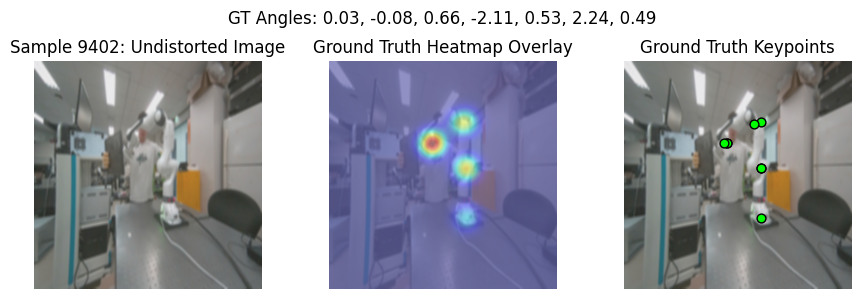

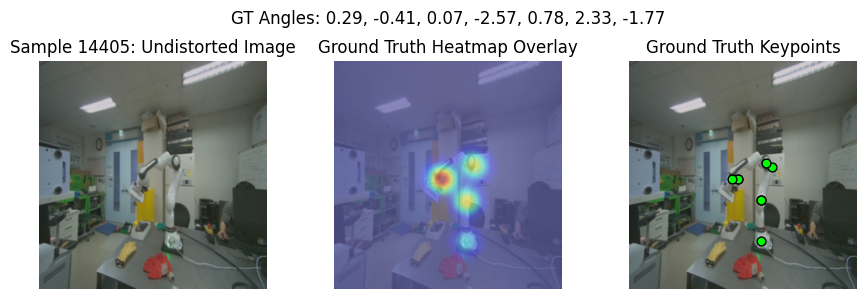

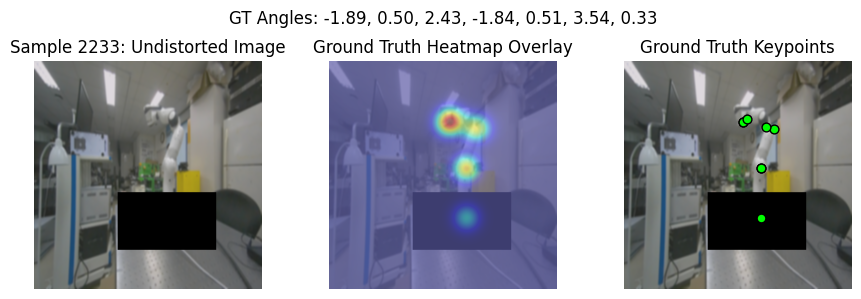


--- Starting Training ---


Epoch 1 [Train]: 100%|██████████| 49/49 [03:51<00:00,  4.72s/it, loss_ang=0.0339, loss_kpt=0.011] 


Epoch 1/100 Summary -> Train Losses [Kpt: 0.014255, Ang: 0.038286], Avg Val Loss: 0.014238
Epoch 1/100 Summary -> Train Losses [Kpt: 0.014255, Ang: 0.038286], Avg Val Loss: 0.014238
  -> Current LRs [Kpt: 0.000100, Ang: 0.000100]
  -> 🎉 New best model saved with validation loss: 0.014238

--- Visualizing Predictions for Epoch 1 ---


Epoch 2 [Train]: 100%|██████████| 49/49 [03:35<00:00,  4.41s/it, loss_ang=0.0251, loss_kpt=0.0139]


Epoch 2/100 Summary -> Train Losses [Kpt: 0.013851, Ang: 0.035022], Avg Val Loss: 0.012784
Epoch 2/100 Summary -> Train Losses [Kpt: 0.013851, Ang: 0.035022], Avg Val Loss: 0.012784
  -> Current LRs [Kpt: 0.000100, Ang: 0.000100]
  -> 🎉 New best model saved with validation loss: 0.012784

--- Visualizing Predictions for Epoch 2 ---


Epoch 3 [Train]: 100%|██████████| 49/49 [03:37<00:00,  4.44s/it, loss_ang=0.039, loss_kpt=0.00969]


Epoch 3/100 Summary -> Train Losses [Kpt: 0.013224, Ang: 0.034395], Avg Val Loss: 0.011825
Epoch 3/100 Summary -> Train Losses [Kpt: 0.013224, Ang: 0.034395], Avg Val Loss: 0.011825
  -> Current LRs [Kpt: 0.000100, Ang: 0.000100]
  -> 🎉 New best model saved with validation loss: 0.011825

--- Visualizing Predictions for Epoch 3 ---


Epoch 4 [Train]: 100%|██████████| 49/49 [03:37<00:00,  4.44s/it, loss_ang=0.0433, loss_kpt=0.0138]


Epoch 4/100 Summary -> Train Losses [Kpt: 0.013277, Ang: 0.032712], Avg Val Loss: 0.012233
Epoch 4/100 Summary -> Train Losses [Kpt: 0.013277, Ang: 0.032712], Avg Val Loss: 0.012233
  -> Current LRs [Kpt: 0.000100, Ang: 0.000100]


Epoch 5 [Train]: 100%|██████████| 49/49 [03:31<00:00,  4.32s/it, loss_ang=0.0431, loss_kpt=0.0107]


Epoch 5/100 Summary -> Train Losses [Kpt: 0.013077, Ang: 0.035210], Avg Val Loss: 0.011292
Epoch 5/100 Summary -> Train Losses [Kpt: 0.013077, Ang: 0.035210], Avg Val Loss: 0.011292
  -> Current LRs [Kpt: 0.000099, Ang: 0.000099]
  -> 🎉 New best model saved with validation loss: 0.011292

--- Visualizing Predictions for Epoch 5 ---


Epoch 6 [Train]: 100%|██████████| 49/49 [03:36<00:00,  4.41s/it, loss_ang=0.016, loss_kpt=0.0084] 


Epoch 6/100 Summary -> Train Losses [Kpt: 0.012640, Ang: 0.033288], Avg Val Loss: 0.011252
Epoch 6/100 Summary -> Train Losses [Kpt: 0.012640, Ang: 0.033288], Avg Val Loss: 0.011252
  -> Current LRs [Kpt: 0.000099, Ang: 0.000099]
  -> 🎉 New best model saved with validation loss: 0.011252

--- Visualizing Predictions for Epoch 6 ---


Epoch 7 [Train]: 100%|██████████| 49/49 [03:36<00:00,  4.42s/it, loss_ang=0.0341, loss_kpt=0.0124]


Epoch 7/100 Summary -> Train Losses [Kpt: 0.012578, Ang: 0.032936], Avg Val Loss: 0.011605
Epoch 7/100 Summary -> Train Losses [Kpt: 0.012578, Ang: 0.032936], Avg Val Loss: 0.011605
  -> Current LRs [Kpt: 0.000099, Ang: 0.000099]


Epoch 8 [Train]: 100%|██████████| 49/49 [03:33<00:00,  4.36s/it, loss_ang=0.0304, loss_kpt=0.0136] 


Epoch 8/100 Summary -> Train Losses [Kpt: 0.012406, Ang: 0.031890], Avg Val Loss: 0.010898
Epoch 8/100 Summary -> Train Losses [Kpt: 0.012406, Ang: 0.031890], Avg Val Loss: 0.010898
  -> Current LRs [Kpt: 0.000098, Ang: 0.000098]
  -> 🎉 New best model saved with validation loss: 0.010898

--- Visualizing Predictions for Epoch 8 ---


Epoch 9 [Train]: 100%|██████████| 49/49 [03:31<00:00,  4.32s/it, loss_ang=0.0452, loss_kpt=0.0189] 


Epoch 9/100 Summary -> Train Losses [Kpt: 0.012131, Ang: 0.031899], Avg Val Loss: 0.011044
Epoch 9/100 Summary -> Train Losses [Kpt: 0.012131, Ang: 0.031899], Avg Val Loss: 0.011044
  -> Current LRs [Kpt: 0.000098, Ang: 0.000098]


Epoch 10 [Train]: 100%|██████████| 49/49 [03:35<00:00,  4.40s/it, loss_ang=0.0291, loss_kpt=0.0114] 


Epoch 10/100 Summary -> Train Losses [Kpt: 0.011969, Ang: 0.031235], Avg Val Loss: 0.011339
Epoch 10/100 Summary -> Train Losses [Kpt: 0.011969, Ang: 0.031235], Avg Val Loss: 0.011339
  -> Current LRs [Kpt: 0.000098, Ang: 0.000098]


Epoch 11 [Train]: 100%|██████████| 49/49 [03:33<00:00,  4.36s/it, loss_ang=0.0213, loss_kpt=0.0114] 


Epoch 11/100 Summary -> Train Losses [Kpt: 0.011414, Ang: 0.029838], Avg Val Loss: 0.010947
Epoch 11/100 Summary -> Train Losses [Kpt: 0.011414, Ang: 0.029838], Avg Val Loss: 0.010947
  -> Current LRs [Kpt: 0.000097, Ang: 0.000097]


Epoch 12 [Train]: 100%|██████████| 49/49 [03:31<00:00,  4.32s/it, loss_ang=0.0499, loss_kpt=0.016]  


Epoch 12/100 Summary -> Train Losses [Kpt: 0.012072, Ang: 0.032821], Avg Val Loss: 0.011184
Epoch 12/100 Summary -> Train Losses [Kpt: 0.012072, Ang: 0.032821], Avg Val Loss: 0.011184
  -> Current LRs [Kpt: 0.000097, Ang: 0.000097]


Epoch 13 [Train]: 100%|██████████| 49/49 [03:29<00:00,  4.27s/it, loss_ang=0.0368, loss_kpt=0.0126] 


Epoch 13/100 Summary -> Train Losses [Kpt: 0.011579, Ang: 0.029943], Avg Val Loss: 0.010468
Epoch 13/100 Summary -> Train Losses [Kpt: 0.011579, Ang: 0.029943], Avg Val Loss: 0.010468
  -> Current LRs [Kpt: 0.000096, Ang: 0.000096]
  -> 🎉 New best model saved with validation loss: 0.010468

--- Visualizing Predictions for Epoch 13 ---


Epoch 14 [Train]: 100%|██████████| 49/49 [03:35<00:00,  4.39s/it, loss_ang=0.0241, loss_kpt=0.0119] 


Epoch 14/100 Summary -> Train Losses [Kpt: 0.012083, Ang: 0.028891], Avg Val Loss: 0.010609
Epoch 14/100 Summary -> Train Losses [Kpt: 0.012083, Ang: 0.028891], Avg Val Loss: 0.010609
  -> Current LRs [Kpt: 0.000095, Ang: 0.000095]


Epoch 15 [Train]: 100%|██████████| 49/49 [03:35<00:00,  4.40s/it, loss_ang=0.0158, loss_kpt=0.0074] 


Epoch 15/100 Summary -> Train Losses [Kpt: 0.011500, Ang: 0.028536], Avg Val Loss: 0.011140
Epoch 15/100 Summary -> Train Losses [Kpt: 0.011500, Ang: 0.028536], Avg Val Loss: 0.011140
  -> Current LRs [Kpt: 0.000095, Ang: 0.000095]


Epoch 16 [Train]: 100%|██████████| 49/49 [03:31<00:00,  4.32s/it, loss_ang=0.0166, loss_kpt=0.0107] 


Epoch 16/100 Summary -> Train Losses [Kpt: 0.011062, Ang: 0.026698], Avg Val Loss: 0.010839
Epoch 16/100 Summary -> Train Losses [Kpt: 0.011062, Ang: 0.026698], Avg Val Loss: 0.010839
  -> Current LRs [Kpt: 0.000094, Ang: 0.000094]


Epoch 17 [Train]: 100%|██████████| 49/49 [03:34<00:00,  4.38s/it, loss_ang=0.0306, loss_kpt=0.017]  


Epoch 17/100 Summary -> Train Losses [Kpt: 0.011239, Ang: 0.028136], Avg Val Loss: 0.010417
Epoch 17/100 Summary -> Train Losses [Kpt: 0.011239, Ang: 0.028136], Avg Val Loss: 0.010417
  -> Current LRs [Kpt: 0.000093, Ang: 0.000093]
  -> 🎉 New best model saved with validation loss: 0.010417

--- Visualizing Predictions for Epoch 17 ---


Epoch 18 [Train]: 100%|██████████| 49/49 [03:34<00:00,  4.39s/it, loss_ang=0.0415, loss_kpt=0.0133] 


Epoch 18/100 Summary -> Train Losses [Kpt: 0.010984, Ang: 0.026852], Avg Val Loss: 0.010849
Epoch 18/100 Summary -> Train Losses [Kpt: 0.010984, Ang: 0.026852], Avg Val Loss: 0.010849
  -> Current LRs [Kpt: 0.000092, Ang: 0.000092]


Epoch 19 [Train]: 100%|██████████| 49/49 [03:32<00:00,  4.33s/it, loss_ang=0.0225, loss_kpt=0.00795]


Epoch 19/100 Summary -> Train Losses [Kpt: 0.010999, Ang: 0.027063], Avg Val Loss: 0.010387
Epoch 19/100 Summary -> Train Losses [Kpt: 0.010999, Ang: 0.027063], Avg Val Loss: 0.010387
  -> Current LRs [Kpt: 0.000091, Ang: 0.000091]
  -> 🎉 New best model saved with validation loss: 0.010387

--- Visualizing Predictions for Epoch 19 ---


Epoch 20 [Train]: 100%|██████████| 49/49 [03:30<00:00,  4.30s/it, loss_ang=0.0159, loss_kpt=0.015]  


Epoch 20/100 Summary -> Train Losses [Kpt: 0.011489, Ang: 0.026668], Avg Val Loss: 0.010473
Epoch 20/100 Summary -> Train Losses [Kpt: 0.011489, Ang: 0.026668], Avg Val Loss: 0.010473
  -> Current LRs [Kpt: 0.000091, Ang: 0.000091]


Epoch 21 [Train]: 100%|██████████| 49/49 [03:33<00:00,  4.37s/it, loss_ang=0.0154, loss_kpt=0.00985]


Epoch 21/100 Summary -> Train Losses [Kpt: 0.010764, Ang: 0.026595], Avg Val Loss: 0.010068
Epoch 21/100 Summary -> Train Losses [Kpt: 0.010764, Ang: 0.026595], Avg Val Loss: 0.010068
  -> Current LRs [Kpt: 0.000090, Ang: 0.000090]
  -> 🎉 New best model saved with validation loss: 0.010068

--- Visualizing Predictions for Epoch 21 ---


/tmp/ipykernel_1063553/58160635.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 4, figsize=(18, 5)) # ✅ figsize도 적절하게 조정
Epoch 22 [Train]: 100%|██████████| 49/49 [03:35<00:00,  4.41s/it, loss_ang=0.0179, loss_kpt=0.00622]


Epoch 22/100 Summary -> Train Losses [Kpt: 0.010844, Ang: 0.026319], Avg Val Loss: 0.010276
Epoch 22/100 Summary -> Train Losses [Kpt: 0.010844, Ang: 0.026319], Avg Val Loss: 0.010276
  -> Current LRs [Kpt: 0.000089, Ang: 0.000089]


Epoch 23 [Train]: 100%|██████████| 49/49 [03:34<00:00,  4.38s/it, loss_ang=0.0248, loss_kpt=0.00956]


Epoch 23/100 Summary -> Train Losses [Kpt: 0.010189, Ang: 0.024950], Avg Val Loss: 0.009658
Epoch 23/100 Summary -> Train Losses [Kpt: 0.010189, Ang: 0.024950], Avg Val Loss: 0.009658
  -> Current LRs [Kpt: 0.000088, Ang: 0.000088]
  -> 🎉 New best model saved with validation loss: 0.009658

--- Visualizing Predictions for Epoch 23 ---


Epoch 24 [Train]: 100%|██████████| 49/49 [03:35<00:00,  4.39s/it, loss_ang=0.0315, loss_kpt=0.0107] 


Epoch 24/100 Summary -> Train Losses [Kpt: 0.010629, Ang: 0.026167], Avg Val Loss: 0.010299
Epoch 24/100 Summary -> Train Losses [Kpt: 0.010629, Ang: 0.026167], Avg Val Loss: 0.010299
  -> Current LRs [Kpt: 0.000087, Ang: 0.000087]


Epoch 25 [Train]: 100%|██████████| 49/49 [03:31<00:00,  4.32s/it, loss_ang=0.0283, loss_kpt=0.0133] 


Epoch 25/100 Summary -> Train Losses [Kpt: 0.010542, Ang: 0.027811], Avg Val Loss: 0.010157
Epoch 25/100 Summary -> Train Losses [Kpt: 0.010542, Ang: 0.027811], Avg Val Loss: 0.010157
  -> Current LRs [Kpt: 0.000086, Ang: 0.000086]


Epoch 26 [Train]: 100%|██████████| 49/49 [03:31<00:00,  4.31s/it, loss_ang=0.0217, loss_kpt=0.00879]


Epoch 26/100 Summary -> Train Losses [Kpt: 0.010715, Ang: 0.026115], Avg Val Loss: 0.009643
Epoch 26/100 Summary -> Train Losses [Kpt: 0.010715, Ang: 0.026115], Avg Val Loss: 0.009643
  -> Current LRs [Kpt: 0.000084, Ang: 0.000084]
  -> 🎉 New best model saved with validation loss: 0.009643

--- Visualizing Predictions for Epoch 26 ---


Epoch 27 [Train]: 100%|██████████| 49/49 [03:30<00:00,  4.30s/it, loss_ang=0.0323, loss_kpt=0.0203] 


Epoch 27/100 Summary -> Train Losses [Kpt: 0.010166, Ang: 0.024455], Avg Val Loss: 0.009880
Epoch 27/100 Summary -> Train Losses [Kpt: 0.010166, Ang: 0.024455], Avg Val Loss: 0.009880
  -> Current LRs [Kpt: 0.000083, Ang: 0.000083]


Epoch 28 [Train]: 100%|██████████| 49/49 [03:34<00:00,  4.37s/it, loss_ang=0.0338, loss_kpt=0.00851]


Epoch 28/100 Summary -> Train Losses [Kpt: 0.010298, Ang: 0.025685], Avg Val Loss: 0.010407
Epoch 28/100 Summary -> Train Losses [Kpt: 0.010298, Ang: 0.025685], Avg Val Loss: 0.010407
  -> Current LRs [Kpt: 0.000082, Ang: 0.000082]


Epoch 29 [Train]: 100%|██████████| 49/49 [03:38<00:00,  4.46s/it, loss_ang=0.0169, loss_kpt=0.00923]


Epoch 29/100 Summary -> Train Losses [Kpt: 0.010316, Ang: 0.023379], Avg Val Loss: 0.009597
Epoch 29/100 Summary -> Train Losses [Kpt: 0.010316, Ang: 0.023379], Avg Val Loss: 0.009597
  -> Current LRs [Kpt: 0.000081, Ang: 0.000081]
  -> 🎉 New best model saved with validation loss: 0.009597

--- Visualizing Predictions for Epoch 29 ---


Epoch 30 [Train]: 100%|██████████| 49/49 [03:38<00:00,  4.45s/it, loss_ang=0.0482, loss_kpt=0.019]  


Epoch 30/100 Summary -> Train Losses [Kpt: 0.010562, Ang: 0.025367], Avg Val Loss: 0.009104
Epoch 30/100 Summary -> Train Losses [Kpt: 0.010562, Ang: 0.025367], Avg Val Loss: 0.009104
  -> Current LRs [Kpt: 0.000080, Ang: 0.000080]
  -> 🎉 New best model saved with validation loss: 0.009104

--- Visualizing Predictions for Epoch 30 ---


Epoch 31 [Train]:  14%|█▍        | 7/49 [01:25<08:32, 12.21s/it, loss_ang=0.0241, loss_kpt=0.0138] 
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
sock

KeyboardInterrupt: 

socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.send() raised exception.
socket.s

In [ ]:
# ==============================================================================
# 3. 학습 및 검증 루프 (Training & Validation Loop) = v2 version
# ==============================================================================
def setup(hyperparameters, dataset_pairs):
    """학습에 필요한 모든 구성 요소를 준비합니다. (CPU Transform 버전)"""
    print("--- Setting up the environment ---")
    
    # --- 1. 하이퍼파라미터 및 장치 설정 ---
    model_name = hyperparameters['model_name']
    batch_size = hyperparameters['batch_size']
    val_split = hyperparameters['val_split']
    num_epochs = hyperparameters['num_epochs']
    lr_kpt = hyperparameters['lr_kpt']
    lr_ang = hyperparameters['lr_ang']
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # --- 2. Transform 정의 (CPU 기반으로 통합) ---
    dino_model_for_config = timm.create_model(model_name, pretrained=True)
    config = dino_model_for_config.default_cfg
    
    # ✅ 학습 데이터용 Transform (증강 포함)
    train_transform = transforms.Compose([
        transforms.Resize(config['input_size'][-2:]),
        transforms.ColorJitter(brightness=0.2, contrast=0.15, saturation=0.15, hue=0.05),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.2, scale=(0.1, 0.2), ratio=(0.3, 2.0)),
        transforms.Normalize(mean=config['mean'], std=config['std'])
    ])

    # ✅ 검증 및 시각화용 Transform (증강 없음)
    val_transform = transforms.Compose([
        transforms.Resize(config['input_size'][-2:]),
        transforms.ToTensor(),
        transforms.Normalize(mean=config['mean'], std=config['std'])
    ])
    
    print("CPU-based transforms created for training and validation.")

    # --- 3. Dataset 및 DataLoader 준비 ---
    indices = torch.randperm(len(dataset_pairs)).tolist()
    train_size = int(len(dataset_pairs) * (1 - val_split))
    train_pairs = [dataset_pairs[i] for i in indices[:train_size]]
    val_pairs = [dataset_pairs[i] for i in indices[train_size:]]
    
    # ✅ 각 데이터셋에 맞는 transform 전달
    train_dataset = RobotPoseDataset(pairs=train_pairs, transform=train_transform)
    val_dataset = RobotPoseDataset(pairs=val_pairs, transform=val_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=24, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True, persistent_workers=True)
    print(f"Dataset split: {len(train_dataset)} training samples, {len(val_dataset)} validation samples.")


    # ✅ --- 4. 모델, 손실 함수, 옵티마이저, 스케줄러 준비 (누락된 부분 추가) ---
    # --------------------------------------------------------------------------
    model = DINOv2PoseEstimator(model_name)

    # DINOv2 백본 동결
    for param in model.backbone.parameters():
        param.requires_grad = False
    
    if torch.cuda.device_count() > 1:
        print(f"Let's use {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
        
    model.to(device)
        
    crit_kpt = nn.MSELoss()
    crit_ang = nn.SmoothL1Loss(beta=1.0)

    model_to_access = model.module if isinstance(model, nn.DataParallel) else model
    
    optimizer_kpt = torch.optim.AdamW(model_to_access.keypoint_head.parameters(), lr=lr_kpt)
    optimizer_ang = torch.optim.AdamW(model_to_access.angle_head.parameters(), lr=lr_ang)

    scheduler_kpt = CosineAnnealingLR(optimizer_kpt, T_max=num_epochs, eta_min=1e-6)
    scheduler_ang = CosineAnnealingLR(optimizer_ang, T_max=num_epochs, eta_min=1e-6)
    
    print(f"Model, losses, and optimizers are ready. Using device: {device}")
    
    return model, train_loader, val_loader, crit_kpt, crit_ang, \
           optimizer_kpt, optimizer_ang, scheduler_kpt, scheduler_ang, \
           device, config, val_transform # vis_transform 대신 val_transform 반환
    # --------------------------------------------------------------------------
# ==============================================================================
# 4. 메인 실행부 (Main Execution)
# ==============================================================================
import time

if __name__ == '__main__':
    
    hyperparameters = {
        'model_name': 'vit_base_patch14_dinov2.lvd142m',
        'batch_size': 300,
        'num_epochs': 100,
        'val_split': 0.1,
        'loss_weight_kpt': 100.0, # FocalLoss를 사용하므로 10로 되돌리거나 조절
        'lr_kpt': 0.0001,
        'lr_ang': 0.0001,
    }
    CHECKPOINT_PATH = '/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/model/checkpoint.pth'
    PRETRAINED_MODEL_PATH = 'best_pose_estimator_model.pth' 
    
    run = wandb.init(
        project="robot-pose-estimation", # wandb 프로젝트 이름
        config=hyperparameters,          # 하이퍼파라미터 저장
        name=f"run_{time.strftime('%Y%m%d_%H%M%S')}" # 실행 이름 (선택 사항)
    )
    
    # --------------------------------------------------------------------------
    # hyperparameters 딕셔너리 전체와 dataset_pairs만 전달합니다.
    model, train_loader, val_loader, crit_kpt, crit_ang, \
    optimizer_kpt, optimizer_ang, scheduler_kpt, scheduler_ang, \
    device, config, vis_transform = setup(
        hyperparameters, dataset_pairs
    )
    # --------------------------------------------------------------------------
    
    wandb.watch(model, log="all", log_freq=100)
    
    start_epoch = 0
    best_val_loss = float('inf')

    if os.path.exists(PRETRAINED_MODEL_PATH):
        print(f"✅ Found checkpoint at '{PRETRAINED_MODEL_PATH}'. Resuming training.")
        # 체크포인트 로드 (CPU에 먼저 로드하여 메모리 오류 방지)
        checkpoint = torch.load(PRETRAINED_MODEL_PATH, map_location='cpu')
        
        # DataParallel 래핑 여부에 따라 state_dict 로드
        model_to_load = model.module if isinstance(model, nn.DataParallel) else model
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model_to_load.load_state_dict(checkpoint['model_state_dict'])
        else:
            model_to_load.load_state_dict(checkpoint)
        
    else:
        print("ℹ️ No pretrained model found. Starting training from scratch.")
    # --------------------------------------------------------------------------

    visualize_dataset_sample(train_loader.dataset, config, num_samples=3)

    # --- 학습 시작 ---
    print("\n--- Starting Training ---")

    # ✅ --- 2. 학습 루프 시작점 수정 ---
    for epoch in range(start_epoch, hyperparameters['num_epochs']):
        train_loss_kpt, train_loss_ang = train_one_epoch(
            model, train_loader, optimizer_kpt, optimizer_ang, crit_kpt, crit_ang, device, loss_weight_kpt=hyperparameters['loss_weight_kpt'], epoch_num=epoch+1
        )
        val_loss = validate(model, val_loader, crit_kpt, crit_ang, device, loss_weight_kpt=hyperparameters['loss_weight_kpt'], epoch_num=epoch+1)
        
        print(f"Epoch {epoch+1}/{hyperparameters['num_epochs']} Summary -> Train Losses [Kpt: {train_loss_kpt:.6f}, Ang: {train_loss_ang:.6f}], Avg Val Loss: {val_loss:.6f}")
        
        # ✅ --- 3. 체크포인트 저장 로직 수정 ---
        # --------------------------------------------------------------------------
        # 현재 에폭의 상태를 체크포인트로 저장 (매 에폭마다 덮어쓰기)
        state_to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': state_to_save,
            'optimizer_kpt_state_dict': optimizer_kpt.state_dict(),
            'optimizer_ang_state_dict': optimizer_ang.state_dict(),
            'best_val_loss': best_val_loss,
        }
        # ✅ 백그라운드 스레드에서 체크포인트 저장
        save_thread = threading.Thread(target=torch.save, args=(checkpoint, CHECKPOINT_PATH))
        save_thread.start() # 저장을 시작하고 바로 다음 코드로 넘어감
        
        scheduler_kpt.step()
        scheduler_ang.step()

        current_lr_kpt = optimizer_kpt.param_groups[0]['lr']
        current_lr_ang = optimizer_ang.param_groups[0]['lr']
        
        print(f"Epoch {epoch+1}/{hyperparameters['num_epochs']} Summary -> Train Losses [Kpt: {train_loss_kpt:.6f}, Ang: {train_loss_ang:.6f}], Avg Val Loss: {val_loss:.6f}")
        print(f"  -> Current LRs [Kpt: {current_lr_kpt:.6f}, Ang: {current_lr_ang:.6f}]")
        
        wandb.log({
            "epoch": epoch + 1,
            "train_loss_kpt": train_loss_kpt,
            "train_loss_ang": train_loss_ang,
            "avg_val_loss": val_loss,
            "lr_kpt": current_lr_kpt,
            "lr_ang": current_lr_ang
        })

        # 최고 성능 모델은 별도로 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # 위에서 이미 저장했으므로, 여기서는 최고 성능 모델을 복사해서 따로 보관
            # torch.save(state_to_save, 'best_pose_estimator_model.pth')
            print(f"  -> 🎉 New best model saved with validation loss: {best_val_loss:.6f}")
            best_model_save_thread = threading.Thread(target=torch.save, args=(state_to_save, 'best_pose_estimator_model.pth'))
            best_model_save_thread.start()
            
            prediction_fig = visualize_predictions(
                model, val_loader.dataset, device, config, epoch_num=epoch + 1, num_samples=3
            )
            wandb.log({"validation_predictions": wandb.Image(prediction_fig)})
            # visualize_predictions(model, val_loader.dataset, device, config, epoch_num=epoch + 1, num_samples=3)
            plt.close(prediction_fig) # 메모리 누수 방지를 위해 figure 닫기
        # --------------------------------------------------------------------------

    if 'save_thread' in locals() and save_thread.is_alive():
        save_thread.join()
        
    if 'best_model_save_thread' in locals() and best_model_save_thread.is_alive():
        best_model_save_thread.join()
        
    print("\n--- Training Finished ---")
    print(f"🏆 Best validation loss: {best_val_loss:.6f}")
    print("Model and checkpoint saved to 'best_pose_estimator_model.pth' and 'checkpoint.pth'")
    
    run.finish()

--- Loading model ---


/tmp/ipykernel_1125679/778280.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Model loaded and set to cuda in eval mode.
Loaded 8 calibration files.
Loaded 16 Aruco entries for both poses.

--- Processing image: zed_41182735_left_1756277570.520.jpg ---
Heatmap scores [0.55264205 0.72799283 0.72778344 0.72136223 0.7169227  0.7168473
 0.7180804  0.72152734]
Visualizing Keypoint Head predictions by confidence...
✅ Camera Pose (PnP) Estimation Successful!

--- Processing image: zed_49429257_left_1756282403.573.jpg ---
Heatmap scores [0.53420115 0.53725386 0.53736347 0.73563623 0.72217214 0.6782368
 0.67739606 0.5980484 ]
Visualizing Keypoint Head predictions by confidence...
✅ Camera Pose (PnP) Estimation Successful!

--- Processing image: zed_49429257_left_1756281300.347.jpg ---
Heatmap scores [0.73525524 0.73143995 0.7308279  0.7223797  0.72391814 0.7293634
 0.7297758  0.72126484]
Visualizing Keypoint Head predictions by confidence...
✅ Camera Pose (PnP) Estimation Successful!

--- Processing image: zed_44377151_right_1756281731.506.jpg ---
Heatmap scores [0.72591

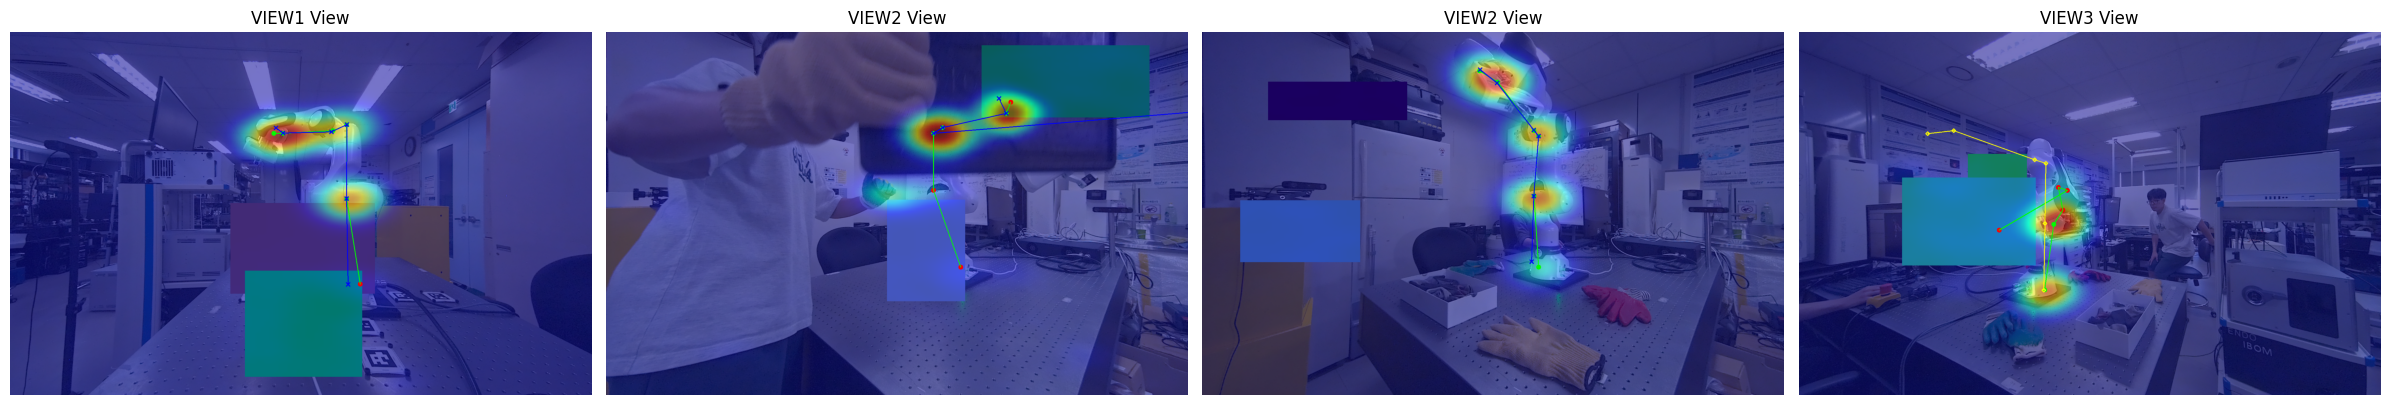

In [9]:
# ==============================================================================
# 1. Helper 함수 (모델 로딩, 키포인트 추출, 포즈 추정)
# ==============================================================================

def load_model(model_path, model_name, device):
    """학습된 모델을 불러와 평가 모드로 설정합니다."""
    print("--- Loading model ---")
    # DINOv2PoseEstimator가 올바른 클래스 이름이라고 가정합니다.
    model = DINOv2PoseEstimator(model_name) 
    state_dict = torch.load(model_path, map_location=device)
    
    # DataParallel로 학습된 경우 'module.' 접두사 제거
    if next(iter(state_dict)).startswith('module.'):
        state_dict = {k[7:]: v for k, v in state_dict.items()}
    
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    print(f"Model loaded and set to {device} in eval mode.")
    return model

def extract_keypoints_from_heatmaps(heatmaps, original_image_size):
    """
    히트맵 텐서에서 2D 좌표와 각 좌표의 신뢰도 점수를 추출합니다.
    """
    num_joints, h, w = heatmaps.shape
    original_h, original_w = original_image_size
    keypoints = np.zeros((num_joints, 2), dtype=np.float32)
    scores = np.zeros(num_joints, dtype=np.float32) # 신뢰도 점수를 저장할 배열 추가

    # 모델의 raw 출력이므로 sigmoid를 적용하여 확률처럼 만듭니다.
    # 만약 FocalLoss 등에서 이미 sigmoid가 적용되었다면 이 부분은 생략 가능합니다.
    heatmaps = heatmaps.sigmoid()

    for i in range(num_joints):
        heatmap = heatmaps[i]
        
        # 1D 텐서로 펼쳐서 최대값과 그 인덱스를 찾습니다.
        flat_heatmap = heatmap.view(-1)
        max_val, max_idx = torch.max(flat_heatmap, dim=0)
        
        # 최대값을 신뢰도 점수로 저장
        scores[i] = max_val.item()
        
        # 1D 인덱스를 2D (y, x) 좌표로 변환합니다.
        y, x = np.unravel_index(max_idx.cpu().numpy(), (h, w))
        
        # 원본 이미지 크기에 맞게 좌표를 스케일링합니다.
        scaled_x = x * (original_w / w)
        scaled_y = y * (original_h / h)
        keypoints[i] = [scaled_x, scaled_y]
        
    return keypoints, scores # 좌표와 점수 모두 반환

def estimate_camera_pose(predicted_angles, predicted_heatmaps, camera_matrix, dist_coeffs, selected_view, original_image_size, confidence_threshold=0.1):
    """
    모델 예측으로부터 FK와 PnP를 통해 카메라 포즈(Rvec, Tvec)를 추정합니다.
    이때, 신뢰도가 낮은 2D 키포인트는 필터링합니다.
    """
    angles_np = predicted_angles.detach().cpu().numpy()
    object_points_3d = angle_to_joint_coordinate(angles_np, selected_view)
    
    # 2. 히트맵에서 2D 좌표와 신뢰도 점수 추출
    image_points_2d, scores = extract_keypoints_from_heatmaps(predicted_heatmaps, original_image_size)
    print(f'Heatmap scores {scores}')
    # ✅ 추가된 부분: 신뢰도 기반 필터링
    # ----------------------------------------------------------------------
    # 신뢰도 점수가 임계값 이상인 점들의 인덱스를 찾습니다.
    high_conf_indices = np.where(scores >= confidence_threshold)[0]
    
    # 해당 인덱스를 사용하여 3D 점과 2D 점을 필터링합니다.
    filtered_object_points_3d = object_points_3d[high_conf_indices]
    filtered_image_points_2d = image_points_2d[high_conf_indices]
    
    # PnP를 실행하기에 점이 충분한지(최소 4개) 확인합니다.
    if len(filtered_image_points_2d) < 4:
        print(f"  -> PnP Failed for '{selected_view}': Not enough high-confidence points found ({len(filtered_image_points_2d)} < 4).")
        return None, None, object_points_3d, image_points_2d # 실패하더라도 전체 점은 시각화를 위해 반환
    # ----------------------------------------------------------------------

    try:
        success, rvec, tvec, inliers = cv2.solvePnPRansac(
            filtered_object_points_3d, 
            filtered_image_points_2d, 
            camera_matrix, 
            dist_coeffs, 
            flags=cv2.SOLVEPNP_EPNP
        )
        
        num_inliers = len(inliers) if inliers is not None else 0
        if success and num_inliers >= 4:
            # ✅ --- 추가: 물리적 타당성 검사 (거리 기반) ---
            # tvec의 L2 norm을 계산하여 카메라와 로봇 베이스 사이의 거리를 구합니다.
            distance = np.linalg.norm(tvec)
            
            # 거리가 물리적으로 타당한 범위 내에 있는지 확인합니다.
            # 이 범위(0.5m ~ 5.0m)는 실제 환경에 맞게 조절해야 합니다.
            if 0.5 < distance < 5.0:
                # 성공 시에는 전체 점들을 반환하여 재투영 시각화에 사용
                return rvec, tvec, object_points_3d, image_points_2d
            else:
                # 거리가 범위를 벗어나면 PnP가 성공했더라도 실패로 처리합니다.
                print(f"  -> PnP Rejected for '{selected_view}': Implausible distance ({distance:.2f}m).")
                return None, None, object_points_3d, image_points_2d
            # ✅ --- 타당성 검사 끝 ---
        else:
            print(f"  -> PnP Failed for '{selected_view}': Success={success}, Inliers={num_inliers}/{len(filtered_image_points_2d)}")
            return None, None, object_points_3d, image_points_2d
            
    except cv2.error as e:
        print(f"PnP calculation failed for view {selected_view}: {e}")
        return None, None, object_points_3d, image_points_2d

def draw_skeleton(image, keypoints, links, color=(0, 255, 0), thickness=2):
    """
    주어진 키포인트들을 links 정보에 따라 선으로 연결합니다.
    이때, NaN 값을 가진 키포인트는 연결에서 제외합니다.
    """
    if keypoints is None or len(keypoints) == 0:
        return image
        
    for start_idx, end_idx in links:
        # 키포인트 인덱스가 유효한 범위 내에 있는지 확인
        if start_idx < len(keypoints) and end_idx < len(keypoints):
            
            start_kp = keypoints[start_idx]
            end_kp = keypoints[end_idx]
            
            # ✅ 추가된 부분: 두 점이 모두 유효한지(NaN이 아닌지) 확인
            # ------------------------------------------------------------------
            if not np.isnan(start_kp).any() and not np.isnan(end_kp).any():
                # 두 점이 모두 유효할 때만 선을 그립니다.
                start_point = tuple(map(int, start_kp.flatten()))
                end_point = tuple(map(int, end_kp.flatten()))
                cv2.line(image, start_point, end_point, color, thickness)
            # ------------------------------------------------------------------

    return image

def overlay_heatmap(image_np, heatmap_tensor, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    원본 이미지 위에 히트맵을 오버레이하여 반환합니다.
    """
    # ✅ 수정된 부분: .numpy() 호출 전에 .detach() 추가
    # ----------------------------------------------------------------------
    heatmap_np = heatmap_tensor.detach().cpu().numpy()
    # ----------------------------------------------------------------------
    
    heatmap_np = (heatmap_np - heatmap_np.min()) / (heatmap_np.max() - heatmap_np.min() + 1e-8)
    heatmap_np = (heatmap_np * 255).astype(np.uint8)

    heatmap_colored = cv2.applyColorMap(heatmap_np, colormap)
    heatmap_colored = cv2.resize(heatmap_colored, (image_np.shape[1], image_np.shape[0]))

    overlaid_image = cv2.addWeighted(image_np, 1 - alpha, heatmap_colored, alpha, 0)
    return overlaid_image

def load_image_and_preprocess(image_path, transform, camera_matrix, dist_coeffs, add_random_mask=False, mask_size_ratio=(0.1, 0.3), num_masks=1):
    """
    이미지를 불러와 왜곡 보정을 수행한 뒤, 원본(시각화용)과 
    전처리된 텐서(모델 입력용)를 반환합니다.
    """
    # 1. 이미지 로드 및 왜곡 보정
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    undistorted_image_np = cv2.undistort(image_np, camera_matrix, dist_coeffs)
    
    # 2. 모델 입력 및 시각화용으로 사용할 이미지의 기반을 undistorted 버전으로 설정
    image_to_process_np = undistorted_image_np.copy()

    # 3. (선택 사항) 마스킹 로직 적용
    if add_random_mask:
        h, w, _ = image_to_process_np.shape
        for _ in range(num_masks):
            mask_w = int(w * random.uniform(mask_size_ratio[0], mask_size_ratio[1]))
            mask_h = int(h * random.uniform(mask_size_ratio[0], mask_size_ratio[1]))
            x_start = random.randint(0, w - mask_w)
            y_start = random.randint(0, h - mask_h)
            image_to_process_np[y_start:y_start+mask_h, x_start:x_start+mask_w] = [random.randint(0,255), random.randint(0,255), random.randint(0,255)]
    
    # ✅ --- 4. (수정) 최종적으로 처리된 이미지를 사용하여 시각화용 및 모델 입력용 데이터를 생성 ---
    # 이제 마스킹이 적용된 image_to_process_np를 사용합니다.
    visualization_image_np = cv2.cvtColor(image_to_process_np, cv2.COLOR_RGB2BGR)
    
    # 모델 입력용 텐서 생성
    image_for_transform_pil = Image.fromarray(image_to_process_np)
    image_tensor = transform(image_for_transform_pil)
        
    return image_tensor, visualization_image_np

# ==============================================================================
# 2. 메인 실행부 (Jupyter Notebook용)
# ==============================================================================

if __name__ == '__main__':
    # --- 설정 ---
    MODEL_PATH = 'best_pose_estimator_model.pth'
    MODEL_NAME = 'vit_base_patch14_dinov2.lvd142m'
    CALIB_DIR = "../dataset/franka_research3/Calib_cam_from_conf"
    CONFIDENCE_THRESHOLD = 0.6
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # --- 1. 공유 리소스 준비 ---
    model = load_model(MODEL_PATH, MODEL_NAME, device)

    # 모델 설정(config) 불러오기 (timm 기반)
    timm_model = timm.create_model(MODEL_NAME, pretrained=False)
    config = timm_model.default_cfg
        
    transform = transforms.Compose([
        transforms.Resize(config['input_size'][-2:]),
        transforms.ToTensor(),
        transforms.Normalize(mean=config['mean'], std=config['std'])
    ])

    # 모든 캘리브레이션 파일 미리 로드
    calib_data_all = {}
    for calib_path in glob.glob(os.path.join(CALIB_DIR, "*.json")):
        filename = os.path.basename(calib_path).replace("_calib.json", "")
        with open(calib_path, 'r') as f:
            calib_data_all[filename] = json.load(f)
    print(f"Loaded {len(calib_data_all)} calibration files.")

    # ✅ --- 수정: pose1과 pose2의 Aruco 데이터를 하나의 조회 테이블로 통합 ---
    aruco_lookup = {}
    for pose_name in ['pose1', 'pose2']:
        aruco_path = f'../dataset/franka_research3/{pose_name}_aruco_pose_summary.json'
        with open(aruco_path, 'r') as f:
            aruco_data = json.load(f)
        for item in aruco_data:
            key = f"{pose_name}_{item['view']}_{item['cam']}" # 'pose1_view1_leftcam' 형식
            aruco_lookup[key] = item
    print(f"Loaded {len(aruco_lookup)} Aruco entries for both poses.")

    # --- 2. 추론할 이미지 목록 ---
    image_paths = [
        '../dataset/franka_research3/franka_research3_pose1/Panda_dataset_5th/view1/zed_41182735_left_1756277570.520.jpg',
        '../dataset/franka_research3/franka_research3_pose2/Panda_dataset_22th_block/view2/zed_49429257_left_1756282403.573.jpg',
        '../dataset/franka_research3/franka_research3_pose2/Panda_dataset_16th_dark1_light1/view2/zed_49429257_left_1756281300.347.jpg',
        '../dataset/franka_research3/franka_research3_pose2/Panda_dataset_18th_dark2/view3/zed_44377151_right_1756281731.506.jpg'
    ]

    # ✅ --- 수정: 누락된 시리얼 번호 추가 ---
    serial_to_view = {
        '41182735': "view1", '49429257': "view2",
        '44377151': "view3", '49045152': "view4"
    }

    # ✅ 관절 8개(0~7)를 연결하는 링크. (0,1), (1,2), ..., (6,7)
    robot_links = [(i, i + 1) for i in range(7)] 

    # --- 3. 메인 추론 및 결과 저장 루프 ---
    visualized_results = []
    
    for path in image_paths:
        if not os.path.exists(path):
            print(f"Image not found: {path}. Skipping.")
            continue
        
        print(f"\n--- Processing image: {os.path.basename(path)} ---")
        

        filename_parts = os.path.basename(path).split('_')
        serial_str, cam_type = filename_parts[1], filename_parts[2] + "cam"
        selected_view = serial_to_view.get(serial_str, "unknown")
        
        calib_key = f"{selected_view}_{serial_str}_{cam_type}"
        if calib_key not in calib_data_all:
            print(f"Calibration data not found for key: {calib_key}. Skipping.")
            continue
        calib = calib_data_all[calib_key]
        camera_matrix = np.array(calib["camera_matrix"], dtype=np.float32)
        dist_coeffs = np.array(calib["distortion_coeffs"], dtype=np.float32)
        image_tensor, original_image = load_image_and_preprocess(path, transform, camera_matrix, dist_coeffs, add_random_mask=True, mask_size_ratio=(0.1, 0.3), num_masks=2)

        pred_heatmaps_batch, pred_angles_batch = model(image_tensor.unsqueeze(0).to(device))
        
        original_size = original_image.shape[:2]
        vis_image = original_image.copy() # 원본 이미지를 복사하여 사용
        
        # ✅ 히트맵 오버레이 추가
        # ----------------------------------------------------------------------
        # 모든 키포인트 히트맵을 합쳐서 하나의 히트맵으로 만듭니다.
        # `pred_heatmaps_batch`의 크기는 (batch_size, num_joints, h, w)
        # 여기서는 첫 번째 샘플의 모든 관절 히트맵을 합칩니다.
        summed_heatmap = torch.sum(pred_heatmaps_batch[0], dim=0) # (num_joints, h, w) -> (h, w)
        
        # 이미지 위에 합쳐진 히트맵을 오버레이
        vis_image_with_heatmap = overlay_heatmap(vis_image, summed_heatmap, alpha=0.5)
        # 이제부터 모든 그림은 vis_image_with_heatmap 위에 그립니다.
        vis_image = vis_image_with_heatmap
        # ----------------------------------------------------------------------

        # PnP를 시도하고 결과를 받음
        rvec, tvec, object_points_3d, image_points_2d = estimate_camera_pose(
            pred_angles_batch[0], pred_heatmaps_batch[0], camera_matrix, 
            dist_coeffs, selected_view, original_size,
            confidence_threshold=CONFIDENCE_THRESHOLD 
        )
        
        pose_name = 'pose1' if 'pose1' in path else 'pose2'
        
        # 2D 키포인트 신뢰도 점수도 다시 추출 (시각화용)
        _, scores = extract_keypoints_from_heatmaps(pred_heatmaps_batch[0], original_size)

        # 신뢰도에 따라 KeypointHead 예측 시각화 (녹색/빨간색 원)
        # 이제는 점의 색상을 바꿔서 히트맵 위에 명확히 보이도록 합니다.
        print("Visualizing Keypoint Head predictions by confidence...")
        # high_conf_points = [] # 이제 이 리스트는 필요 없습니다.
        for i, pt in enumerate(image_points_2d):
            score = scores[i]
            center = tuple(map(int, pt.flatten()))
            if score >= CONFIDENCE_THRESHOLD:
                cv2.circle(vis_image, center, 8, (0, 255, 0), -1) # 녹색 원
            else:
                cv2.circle(vis_image, center, 8, (0, 0, 255), -1) # 빨간색 원 (낮은 신뢰도)

        # KeypointHead 예측 스켈레톤 그리기 (신뢰도 높은 점들만 연결)
        visible_keypoints = np.full((len(image_points_2d), 2), np.nan, dtype=np.float32)
        high_conf_indices = np.where(scores >= CONFIDENCE_THRESHOLD)[0]
        visible_keypoints[high_conf_indices] = image_points_2d[high_conf_indices]
        # 스켈레톤은 여전히 모든 키포인트 정보 (visible_keypoints)를 기반으로 그리되,
        # 유효한 점들만 연결되도록 draw_skeleton 내부 로직이 처리합니다.
        draw_skeleton(vis_image, image_points_2d, robot_links, color=(0, 255, 0), thickness=2) # 녹색 선

        # PnP 성공/실패에 따른 시각화
        if rvec is not None:
            print("✅ Camera Pose (PnP) Estimation Successful!")
            reprojected_points, _ = cv2.projectPoints(object_points_3d, rvec, tvec, camera_matrix, dist_coeffs)
            reprojected_points = reprojected_points.reshape(-1, 2)
            
            # ✅ --- 추가된 부분: 유효하지 않은 좌표 필터링 ---
            # np.isfinite()를 사용하여 NaN이나 무한대 값이 포함된 점을 걸러냅니다.
            # .all(axis=1)는 (x, y) 좌표 둘 다 유효한 경우에만 True를 반환합니다.
            valid_points_mask = np.isfinite(reprojected_points).all(axis=1)
            valid_reprojected_points = reprojected_points[valid_points_mask]
            
            # 유효한 점들만 사용하여 시각화를 진행합니다.
            for pt in valid_reprojected_points:
                cv2.drawMarker(vis_image, tuple(map(int, pt.flatten())), (255, 0, 0), # 파란색 X
                            markerType=cv2.MARKER_TILTED_CROSS, markerSize=12, thickness=2)
                                
            # 재투영 결과 스켈레톤 그리기
            # draw_skeleton 함수는 내부에 NaN 체크 로직이 있으므로, 
            # reprojected_points를 그대로 사용해도 안전합니다.
            draw_skeleton(vis_image, reprojected_points, robot_links, color=(255, 0, 0), thickness=2) # 파란색 선

        else:
            print("❌ Camera Pose (PnP) Estimation Failed.")
            print("  -> Visualizing Angle Head prediction based on initial Aruco pose.")
            
            # ✅ --- 수정: 이미지 경로에 맞는 동적 Aruco 키 생성 ---
            aruco_key = f"{pose_name}_{selected_view}_{cam_type}"
            if aruco_key in aruco_lookup:
                aruco_result = aruco_lookup[aruco_key]
                angles_np = pred_angles_batch[0].detach().cpu().numpy()
                projected_3d_points = joint_coordinate_to_pixel_plane(
                    angle_to_joint_coordinate(angles_np, selected_view),
                    aruco_result, camera_matrix, dist_coeffs
                )
            for pt in projected_3d_points:
                cv2.drawMarker(vis_image, tuple(map(int, pt.flatten())), (0, 255, 255), # 청록색 다이아몬드
                            markerType=cv2.MARKER_DIAMOND, markerSize=12, thickness=2)
                            
            # AngleHead 예측 기반 스켈레톤 그리기
            
            draw_skeleton(vis_image, projected_3d_points, robot_links, color=(0, 255, 255), thickness=2) # 청록색 선
            
        visualized_results.append({'image': vis_image, 'title': f"{selected_view.upper()} View"})

    # --- 4. Matplotlib으로 최종 결과 시각화 ---
    num_images = len(visualized_results)
    fig, axes = plt.subplots(1, num_images, figsize=(6 * num_images, 6))
    if num_images == 1:
        axes = [axes]


    for i, result in enumerate(visualized_results):
        rgb_image = cv2.cvtColor(result['image'], cv2.COLOR_BGR2RGB)
        axes[i].imshow(rgb_image)
        axes[i].set_title(result['title'])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import timm
from PIL import Image
from torchvision import transforms
import numpy as np
import os

# --- 2. Multi-View Fusion Module using Cross-Attention ---
class MultiViewFusion(nn.Module):
    """
    Fuses features from multiple views using self-attention, which acts
    as cross-attention when tokens from all views are concatenated.
    """
    def __init__(self, feature_dim=768, num_heads=8, dropout=0.1):
        super().__init__()
        self.feature_dim = feature_dim
        # The core component: Multi-Head Attention layer
        self.attention = nn.MultiheadAttention(
            embed_dim=feature_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True  # Expects input shape [B, N, D]
        )
        # Standard Transformer components
        self.layer_norm1 = nn.LayerNorm(feature_dim)
        self.layer_norm2 = nn.LayerNorm(feature_dim)
        self.mlp = nn.Sequential(
            nn.Linear(feature_dim, feature_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim * 4, feature_dim),
            nn.Dropout(dropout)
        )

    def forward(self, view_features):
        # view_features: A list of tensors, e.g., [view1_tokens, view2_tokens, view3_tokens]
        # Each tensor has shape [1, NumPatches, FeatureDim]
        
        # Concatenate tokens from all views into a single sequence
        # Shape becomes [1, TotalNumPatches, FeatureDim]
        all_tokens = torch.cat(view_features, dim=1)
        
        # --- Self-Attention as Cross-Attention ---
        # The attention mechanism will calculate scores between every token pair.
        # This allows tokens from view 1 to attend to tokens from view 2 and 3,
        # effectively performing cross-view attention.
        attn_output, _ = self.attention(
            query=all_tokens,
            key=all_tokens,
            value=all_tokens
        )
        
        # First residual connection and layer norm
        x = self.layer_norm1(all_tokens + attn_output)
        
        # MLP part
        mlp_output = self.mlp(x)
        
        # Second residual connection and layer norm
        fused_features = self.layer_norm2(x + mlp_output)
        
        return fused_features

# --- 3. Main Execution Logic ---
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize models
    backbone = DINOv2Backbone().to(device).eval()
    # The feature dimension of DINOv2-Base is 768
    fusion_module = MultiViewFusion(feature_dim=768).to(device).eval()

    # Define image paths
    image_paths = [
        "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_4th_250526/left/zed_38007749_left_1748249112.409.jpg",
        "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_4th_250526/right/zed_34850673_left_1748249112.387.jpg",
        "/home/najo/NAS/DIP/2025_ICRA_Multi_View_Robot_Pose_Estimation/dataset/Fr5/Fr5_4th_250526/top/zed_30779426_left_1748249112.398.jpg"
    ]

    # --- Step A: Extract features for each view ---
    print("\n--- 1. Extracting features from each view ---")
    list_of_features = []
    for path in image_paths:
        print(f"Processing: {os.path.basename(path)}")
        patch_tokens = backbone(path)
        list_of_features.append(patch_tokens)
        print(f"  > Extracted feature shape: {patch_tokens.shape}")

    # --- Step B: Fuse features using the attention module ---
    print("\n--- 2. Fusing features with Multi-Head Cross-Attention ---")
    # The module expects a list of feature tensors
    fused_representation = fusion_module(list_of_features)

    # --- Step C: Show the final result ---
    print("\n--- 3. Final Fused Representation ---")
    print(f"Shape of the final fused feature map: {fused_representation.shape}")
    print("\nThis fused representation is now ready for the prediction heads (Keypoints and Angles).")
    

Using device: cuda

--- 1. Extracting features from each view ---
Processing: zed_38007749_left_1748249112.409.jpg


AttributeError: 'str' object has no attribute 'shape'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from PIL import Image
from torchvision import transforms
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt

# --- Constants for the Model ---
NUM_JOINTS = 7
FEATURE_DIM = 768
HEATMAP_SIZE = (128, 128)

# ===================================================================
# 🏗️ STEP 1: DEFINE ALL MODEL COMPONENTS
# ===================================================================

class DINOv2Backbone(nn.Module):
    def __init__(self, model_name='vit_base_patch14_dinov2.lvd142m'):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True)
        self.config = self.model.default_cfg
        self.transform = transforms.Compose([
            transforms.Resize(self.config['input_size'][-2:]),
            transforms.ToTensor(),
            transforms.Normalize(mean=self.config['mean'], std=self.config['std'])
        ])

    def forward(self, image_path):
        image = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(image).unsqueeze(0).to(next(self.model.parameters()).device)
        features = self.model.forward_features(input_tensor)
        return features[:, 1:, :]

class MultiViewFusion(nn.Module):
    def __init__(self, feature_dim=FEATURE_DIM, num_heads=8, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(feature_dim, num_heads, dropout=dropout, batch_first=True)
        self.layer_norm1 = nn.LayerNorm(feature_dim)
        self.layer_norm2 = nn.LayerNorm(feature_dim)
        self.mlp = nn.Sequential(
            nn.Linear(feature_dim, feature_dim * 4), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(feature_dim * 4, feature_dim), nn.Dropout(dropout)
        )

    def forward(self, view_features):
        all_tokens = torch.cat(view_features, dim=1)
        attn_output, _ = self.attention(all_tokens, all_tokens, all_tokens)
        x = self.layer_norm1(all_tokens + attn_output)
        mlp_output = self.mlp(x)
        return self.layer_norm2(x + mlp_output)

class AngleHead(nn.Module):
    def __init__(self, input_dim=FEATURE_DIM, num_joints=NUM_JOINTS):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 512), nn.GELU(), nn.LayerNorm(512),
            nn.Linear(512, 256), nn.GELU(), nn.LayerNorm(256),
            nn.Linear(256, num_joints)
        )
    def forward(self, fused_features):
        global_features = fused_features.mean(dim=1)
        return self.mlp(global_features)

class KeypointHead(nn.Module):
    def __init__(self, input_dim=FEATURE_DIM, num_joints=NUM_JOINTS):
        super().__init__()
        self.reshape_size = 64
        upsample_channels = [256, 128, 64]
        layers = []
        in_channels = input_dim
        for out_channels in upsample_channels:
            layers.extend([
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.GELU(), nn.BatchNorm2d(out_channels)
            ])
            in_channels = out_channels
        layers.append(nn.ConvTranspose2d(in_channels, num_joints, kernel_size=4, stride=2, padding=1))
        self.upsampler = nn.Sequential(*layers)

    def forward(self, fused_features):
        tokens = fused_features[:, :self.reshape_size**2, :]
        b, n, d = tokens.shape
        h = w = int(np.sqrt(n))
        feature_map = tokens.permute(0, 2, 1).reshape(b, d, h, w)
        heatmaps = self.upsampler(feature_map)
        return F.interpolate(heatmaps, size=HEATMAP_SIZE, mode='bilinear', align_corners=False)

# ===================================================================
# 🤖 STEP 2: ASSEMBLE THE FULL MODEL
# ===================================================================

class RobotPoseEstimator(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = DINOv2Backbone()
        self.fusion_module = MultiViewFusion()
        self.angle_head = AngleHead()
        self.keypoint_head = KeypointHead()

    def forward(self, image_paths, device):
        timings = {}

        # --- Part A: Backbone Feature Extraction ---
        start_time = time.time()
        list_of_features = [self.backbone(path) for path in image_paths]
        if device.type == 'cuda': torch.cuda.synchronize()
        timings['A_Backbone_Extraction'] = time.time() - start_time
        
        # --- Part B: Multi-view Feature Fusion ---
        start_time = time.time()
        fused_features = self.fusion_module(list_of_features)
        if device.type == 'cuda': torch.cuda.synchronize()
        timings['B_Feature_Fusion'] = time.time() - start_time
        
        # --- Part C: Prediction Heads ---
        start_time = time.time()
        predicted_angles = self.angle_head(fused_features)
        predicted_heatmaps = self.keypoint_head(fused_features)
        if device.type == 'cuda': torch.cuda.synchronize()
        timings['C_Prediction_Heads'] = time.time() - start_time
        
        return predicted_angles, predicted_heatmaps, timings

# ===================================================================
# 🚀 STEP 3: RUN AND TIME THE FULL PIPELINE
# ===================================================================

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # --- Timed Step 1: Model Initialization ---
    print("--- 1. Initializing Full Model ---")
    start_time = time.time()
    full_model = RobotPoseEstimator().to(device).eval()
    if device.type == 'cuda': torch.cuda.synchronize()
    print(f"✅ Model initialization took: {time.time() - start_time:.4f} seconds\n")

    # Define image paths
    image_paths = [
        "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/left/zed_38007749_left_1748248620.487.jpg",
        "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/right/zed_34850673_left_1748248620.483.jpg",
        "/home/najo/NAS/DIP/datasets/Fr5_intertek_dataset/Fr5_intertek_1th_250526/top/zed_30779426_left_1748248620.496.jpg"
    ]

    # --- Timed Step 2: Full Inference Pass ---
    print("--- 2. Running Full Inference Pass ---")
    start_time = time.time()
    with torch.no_grad():
        angles, heatmaps, timings = full_model(image_paths, device)
    if device.type == 'cuda': torch.cuda.synchronize()
    total_inference_time = time.time() - start_time
    
    print("✅ Full inference finished.\n")
    print("--- Performance Breakdown ---")
    for step, duration in timings.items():
        print(f"  - {step}: {duration:.4f} seconds")
    print(f"  ---------------------------------")
    print(f"  Total Inference Time: {total_inference_time:.4f} seconds")
    print(f"  Estimated FPS: {1 / total_inference_time:.2f}\n")
    
    print("--- Output Shapes ---")
    print(f"  - Predicted Angles Shape: {angles.shape}")
    print(f"  - Predicted Heatmaps Shape: {heatmaps.shape}")